# Imports

In [1]:
import torch
import string
from tqdm.notebook import tqdm

import torchmetrics

import os
import torchvision.utils
import pandas as pd
from torchvision.io import read_image
import re
import glob
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np

# Loading data

В датасете помимо png файлов было 30 jpg файлов, которые я решил убрать для упрощения

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        #img_dir = ./samples/
        self.img_paths = glob.glob(img_dir + "*.png") # we will ignore 30 jpeg files for now
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = re.split(r'[./]', img_path)[-2]  # ['', '', 'samples', 'p5g5m', 'png'], so [-2] returns label 
        
        image = read_image(img_path, mode = torchvision.io.ImageReadMode.RGB)

        if self.transform:
            image = self.transform(image).float()/255 # automatic convertion to float in the end

        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
CAPTCHA_SIZE = 5
img_dir = './samples/'
transform = torchvision.transforms.Compose([
    #torchvision.transforms.Grayscale(num_output_channels=1)
    #, torchvision.transforms.Normalize(train_mean, train_std)
])

dataset = CustomImageDataset('./samples/', transform=transform)

Проверим, что все считывается нормально (лейбл считывается корректно и сама картинка 50х200 с тремя каналами)

In [4]:
print(dataset[0][0]) # tensor with type float
print(dataset[0][1]) # label
print(dataset[0][0].shape) #tensor shape

tensor([[[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.

Размер датасета:

In [5]:
len(dataset)

1040

Посмотрим на пример картинки:

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

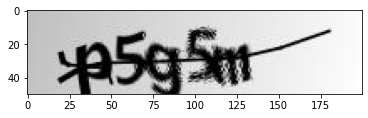

('p5g5m',)


In [7]:
def imshow(img):
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(dataloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(labels)

Разделим выборку на трейн и тест в отношении 1 к 4

In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [9]:
print(f'{len(train_dataset) = }\n{len(test_dataset) = }')

len(train_dataset) = 832
len(test_dataset) = 208


## Dataloaders

In [10]:
batch_size = 26

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True)

Попробуем считать несколько изображений сразу

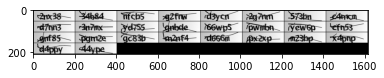

('2nx38', '34b84', 'nfcb5', 'g2fnw', 'd3ycn', '2g7nm', '573bn', 'c4mcm', 'd7nn3', '3n7mx', 'yd755', 'gnbde', '66wp5', 'pwmbn', 'yew6p', 'cfn53', 'gnf85', 'pgm2e', 'gc83b', 'm2nf4', 'd666m', 'px2xp', 'm23bp', 'x4pnp', 'd4ppy', '44ype')


In [11]:
trainiter = iter(trainloader)
images, labels = trainiter.next()

imshow(torchvision.utils.make_grid(images))

print(labels)

## Symbols

Будем использовать только те символы, что есть в датасете

In [13]:
symbols = set()
for i in range(len(dataset)):
    symbols = symbols.union(set(dataset[i][1]))
list(symbols)

['e',
 'g',
 'x',
 'n',
 'w',
 'y',
 '7',
 'b',
 '5',
 '2',
 '4',
 '3',
 'p',
 '8',
 'c',
 'd',
 '6',
 'f',
 'm']

In [14]:
chars = ''
for char in list(symbols):
    chars += char
n_chars = len(chars) # number of symbols
print(n_chars)
print(chars)

19
egxnwy7b5243p8cd6fm


In [22]:
idx_to_char = {idx + 1: token for idx, token in enumerate(chars)}

char_to_idx = {token: idx + 1 for idx, token in enumerate(chars)}

Добавим нейтральный символ

In [23]:
idx_to_char[0] = '-'
char_to_idx['-'] = 0

# Training function and model definition

In [53]:
def train_model(net, criterion, optimizer, trainloader, num_epochs=5):
    cer_test_results = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        net.train()
        for i, data in tqdm(enumerate(trainloader, 0)):
            inputs, labels = data
            target = torch.Tensor([[char_to_idx[char] for char in label] for label in labels])
            
            optimizer.zero_grad()
            
            _, loss = net(inputs, target)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
        else:    
            print('Epoch {0}/{1}, iteration {2}, loss: {3:.3f}'.format(epoch + 1, num_epochs, i + 1, running_loss / len(train_dataset)))
            running_loss = 0.0
        print()
        
        net.eval()
        
        with torch.no_grad():
            fin_loss = 0
            fin_preds = []
            all_labels = []
            for i, data in tqdm(enumerate(testloader, 0)):
                inputs, labels = data    
                all_labels += labels
                
                target = torch.Tensor([[char_to_idx[char] for char in label] for label in labels])
                batch_preds, loss = net(inputs, target)       

                fin_preds.append(batch_preds)
                fin_loss += loss.item()

            print(f"test loss: for {epoch = } is {fin_loss / len(test_dataset)}")
            print('One prediction')
            print('\t batch_pred shape: ', batch_preds.shape)
            print('\t prediction for 0th word:', [idx_to_char[torch.argmax(sym[0]).item()] for sym in batch_preds])
            print('\t distribution for 0th word:') 
            for sym in batch_preds:
                print('\t\t', sym[0])
            print('\tReal_label for 0th: ', labels[0])
            

            print('\t prediction for 1st word:', [idx_to_char[torch.argmax(sym[1]).item()] for sym in batch_preds])
            print('\t distribution for 1st word:') 
            for sym in batch_preds:
                print('\t\t', sym[1])
            print('\tReal_label for 1st: ', labels[1])
        
    print('Finished Training')
    
    return net, fin_preds, all_labels


In [25]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = nn.Conv2d(3, 32, kernel_size=(3, 5), padding='same')
        self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_2 = nn.Conv2d(32, 32, kernel_size=(3, 5), padding='same')
        self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.linear_1 = nn.Linear(768 // 2, 32)
        self.drop_1 = nn.Dropout(0.2)
        self.lstm = nn.GRU(32, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, n_chars + 1)    
        

    def forward(self, x, targets = None):
        
        bs = x.size(0)
        #print(x.shape)
        x = F.relu(self.conv_1(x))
        #print(x.shape)
        x = self.pool_1(x)
        #print(x.shape)
        x = F.relu(self.conv_2(x))
        #print(x.shape)
        x = self.pool_2(x)
        #print(x.shape)
        x = x.permute(0, 3, 1, 2)
        #print(x.shape)
        x = x.view(bs, x.size(1), -1) # x.size(0) instead of batch size
        #print(x.shape)
        x = F.relu(self.linear_1(x))
        #print(x.shape)
        x = self.drop_1(x)
        #print(x.shape)
        x, _ = self.lstm(x)
        #print(x.shape)
        x = self.output(x)
        #print(x.shape)
        x = x.permute(1, 0, 2)
        #print(x.shape)
        #print('===========')
        if targets is not None:
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(
                size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32
            )
            #print(type(targets))
            target_lengths = torch.full(
                size=(bs,), fill_value=targets.size(1), dtype=torch.int32
            )
            loss = nn.CTCLoss(blank=0)(
                log_probs, targets, input_lengths, target_lengths
            )
            return x, loss

        return x, None


net = Net()

# Training the model

In [26]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

In [27]:
net

Net(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 5), stride=(1, 1), padding=same)
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(32, 32, kernel_size=(3, 5), stride=(1, 1), padding=same)
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=384, out_features=32, bias=True)
  (drop_1): Dropout(p=0.2, inplace=False)
  (lstm): GRU(32, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=20, bias=True)
)

In [ ]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=50)

In [ ]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=50)

In [ ]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=50)

# Decoding the results

Запустим одну итерацию чтобы получить результаты

In [ ]:
net, test_preds, test_labels = train_model(net, criterion, optimizer, trainloader, num_epochs=1)

В results запишем подряд полученные последовательности

In [57]:
results = []
for batch_pred in test_preds:
    for i in range(batch_size):
        results.append([idx_to_char[torch.argmax(sym[i]).item()] for sym in batch_pred])
results[0]

['-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 'f',
 '-',
 '-',
 '-',
 '-',
 '7',
 '-',
 '-',
 '-',
 'c',
 '-',
 '-',
 '-',
 '-',
 'e',
 '-',
 '-',
 '-',
 '-',
 '-',
 'y',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-']

Напишем функцию перевода данной последовательности в лейбл

In [60]:
def seq_to_label(ch_list):
    curr_sym = ch_list[0]
    res = ''
    for i in range(len(ch_list)):
        curr_sym = ch_list[i]
        if ch_list[i] != '-' and (i == len(ch_list) - 1 or ch_list[i + 1] == '-'):
            res += ch_list[i]
        if ch_list[i] == '-':
            continue
    return res
            
pred_labels = [seq_to_label(res_elem) for res_elem in results]
pred_labels

['f7cey',
 'cwdnx',
 '6n443',
 'd2nbn',
 '76y6f',
 'w8f36',
 '2bg48',
 'xe6eb',
 'pym7p',
 'dc436',
 'de45x',
 '46mbm',
 '474ff',
 '42xpy',
 '785n4',
 'dfnx4',
 '8npd5',
 'd66cn',
 '8eggg',
 'm8gmx',
 '5ng6e',
 'b5dn4',
 '25p2m',
 '8nn73',
 'gecmf',
 'mfc35',
 '87d4c',
 '478nx',
 'f8f8g',
 '2cgyx',
 'w4x2m',
 '3ebnn',
 'bw44w',
 'ncw4g',
 'exycn',
 '72m6f',
 'bdbb3',
 '3bnyf',
 '68wfd',
 'c6we6',
 'c753e',
 '2mg87',
 '243mm',
 'mc8w2',
 '8fexn',
 'ncfgb',
 'mye68',
 '4ycex',
 'g3dy6',
 'gny6b',
 '2356g',
 '646x8',
 'fdpgd',
 '56c34',
 'nfndw',
 '6gnm3',
 'x775w',
 'enn7n',
 'pwn5e',
 '658xe',
 'cb8cf',
 'ne325',
 'ypw3d',
 'dbex3',
 '63824',
 'nm248',
 'n3m6x',
 'dw6mn',
 '2npg6',
 'x277e',
 'cnex4',
 '8n2pg',
 '5bb66',
 'n3ffn',
 '8xef7',
 '25257',
 'g7wxw',
 '33ng4',
 'ybfx6',
 'cfc56',
 'wpmp',
 'gw468',
 'ycmcw',
 '37d52',
 '2wx73',
 'defyx',
 'deep5',
 'e3ndn',
 '7bwm2',
 'f5cm2',
 'w4nfx',
 '537nf',
 '8nbew',
 '62nb3',
 'y2ye8',
 '7dyww',
 'fywb8',
 '3cpwb',
 'cpc8c',
 'dcnp8',
 

Посчитаем CER

In [64]:
cer_test = torchmetrics.functional.char_error_rate(preds=pred_labels, target=test_labels)
cer_test.item()

0.005769230891019106

# Описание

Изначально была попытка обойтись совсем без RNN. Была идея собрать несколько сверточных слоев, а затем разделить на 5 выходов (для каждого символа капчи соответственно) и при обучении каждому подавать таргет, соответствующий позиции символа. Идея ни к чему хорошему не привела, получилось добиться CER на тесте лишь 0.8. Но надеждый были, ведь CER на тесте стабильно опускался с 0.95, хоть и делал это очень медленно. В итоге решил использовать RNN после сверточных слоев. Сначала аналогично не получалось добиться никаких результатов, выглядело так, что допущена ошибка в коде, однако после упрощения структуры и изменения параметров обучения получилось добиться хорошей точности.

In [2]:
#for i in range(len(pred_labels)):
#    print(pred_labels[i], test_labels[i], torchmetrics.functional.char_error_rate(pred_labels[i], test_labels[i]))
          